In [109]:
import numpy as np
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from tensorflow.keras import layers
import itertools
from collections import Counter
import shutil
import csv
import keras_tuner as kt
from tensorflow import keras
from PIL import Image


In [2]:
#delete .DS_Store files that can get in the way
!find . -name ".DS_Store" -print -delete


./image_processing_tiling/.DS_Store
./.DS_Store
./ImageClassification/lib/python3.11/site-packages/.DS_Store


In [19]:
class_names = ['no meniscus tear', 'meniscus tear']
nClasses = len(class_names)
print("Num classes:", nClasses, "classes (0 1):", class_names)

Num classes: 2 classes (0 1): ['no meniscus tear', 'meniscus tear']


In [70]:

#########training images############
train_folder_path_images = 'MRNet-v1.0/train/rgb_stacks'  # update to folder containing 2D images
train_images = sorted(os.listdir(train_folder_path_images))
train_nImages = len(train_images)
print("Num Images train:",train_nImages)
print("train_images[0]:",train_images[0])



#####training labels#####      
temp,train_labels = np.loadtxt("MRNet-v1.0/train-meniscus.csv",
                 delimiter=",", dtype=int, unpack=True) #need to unpack when using the given csv's with 2 columns
print(train_labels)
train_labels = list(train_labels)


#ensure the number of labels matches the number of imag
train_labelsCropped = train_labels[:train_nImages]
print("Num labels train:", len(train_labelsCropped))


print("============================")

#####validation images#####
valid_folder_path_images = 'MRNet-v1.0/valid/rgb_stacks'  # update to folder containing 2D images
valid_images = sorted(os.listdir(valid_folder_path_images))
# valid_images = sorted([f for f in os.listdir(valid_folder_path_images) if f.lower().endswith('.jpeg')])
valid_nImages = len(valid_images)
print("Num Images valid:",valid_nImages)
print("valid_images[0]:",valid_images[0])

########validation labels############# 
temp,valid_labels = np.loadtxt("MRNet-v1.0/valid-meniscus.csv",
                 delimiter=",", dtype=int, unpack=True) #need to unpack when using the given csv's with 2 columns
valid_labels = list(valid_labels)
#ensure the number of labels matches the number of imag
valid_labelsCropped = valid_labels[:valid_nImages]
print("Num labels valid:", len(valid_labelsCropped))


labels_counter = Counter(train_labelsCropped)
print("train labels", labels_counter)
labels_counter = Counter(valid_labelsCropped)
print("valid labels", labels_counter)

Num Images train: 1130
train_images[0]: rgbAxes_0000.jpeg
[0 1 0 ... 0 0 0]
Num labels train: 1130
Num Images valid: 120
valid_images[0]: rgbAxes_1130.jpeg
Num labels valid: 120
train labels Counter({0: 733, 1: 397})
valid labels Counter({0: 68, 1: 52})


In [106]:
def balance_dataset(images_path,labels,binary_label_name):
    labels_counter = Counter(labels)
    print("label count pre balance", labels_counter)
    train_images = sorted(os.listdir(images_path))
    
    # Determine the count of the least common label
    min_label_count = min(labels_counter.values())
    
    balanced_labels = []
    balanced_images = []
    
    #fill balanced arrays with images and respective labels while count of each label is less than min_count
    for label, image in zip(labels, train_images):       
        bal_labels_counter = Counter(balanced_labels)
        if bal_labels_counter[label] <= min_label_count:
            balanced_labels.append(label)
            balanced_images.append(image)
        
    #folder containing folder with images to balance, balanced images will be saved here in a sub folder
    folder_path = os.path.dirname(images_path)
    
    #get current path and create new folder to save data in current path
    balanced_images_path = os.path.join(os.getcwd(), folder_path, binary_label_name)
    if not os.path.exists(balanced_images_path): 
        os.makedirs(balanced_images_path)

    # Assuming the files are in the current directory, copy balanced images to new folder
    for file_name in balanced_images:

        file_path = os.path.join(images_path, file_name)
        shutil.copy(file_path, balanced_images_path)    

    # Name for the CSV file
    csv_name = binary_label_name + '.csv'
    csv_path = os.path.join(os.getcwd(), csv_name)
    print(csv_path)
    if not os.path.exists(csv_name): 
        np.savetxt(csv_name, balanced_labels, delimiter=",", fmt = '%d') 
    print("\nSaved csv:", csv_name, "in path", os.getcwd())
    print("\nPath to balanced images being returned:", balanced_images_path)
    
    
    return balanced_images_path,balanced_labels


<font size=5> Balance Datasets

In [107]:
bal_imgs_path_train, bal_labels_train = balance_dataset(train_folder_path_images,train_labelsCropped,'balanced_meniscus_rgb_stacks')

bal_imgs_path_valid, bal_labels_valid = balance_dataset(valid_folder_path_images,valid_labelsCropped,'balanced_meniscus_rgb_stacks')

label count pre balance Counter({0: 733, 1: 397})
/Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification/balanced_meniscus_rgb_stacks.csv

Saved csv: balanced_meniscus_rgb_stacks.csv in path /Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification

Path to balanced images being returned: /Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification/MRNet-v1.0/train_4x4_cropped/balanced_meniscus_rgb_stacks
label count pre balance Counter({0: 68, 1: 52})
/Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification/balanced_meniscus_rgb_stacks.csv

Saved csv: balanced_meniscus_rgb_stacks.csv in path /Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification

Path to balanced images being returned: /Users/danielsloseris/Desktop/CMPT 340/Project/ImageClassification/MRNet-v1.0/valid_4x4_cropped/balanced_meniscus_rgb_stacks


In [125]:
#label counts post balancing:
print("train label counts:", Counter(bal_labels_train))
print("valid label counts:",Counter(bal_labels_valid))

print("num train imgs:", len(os.listdir(bal_imgs_path_train)), "num train labels:",len(bal_labels_train))
print("num valid imgs:", len(os.listdir(bal_imgs_path_valid)), "num valid labels:",len(bal_labels_valid))

train label counts: Counter({0: 398, 1: 397})
valid label counts: Counter({0: 53, 1: 52})
num train imgs: 795 num train labels: 795
num valid imgs: 105 num valid labels: 105


<font size=5> Create tf datasets, (batch and shuffle)

In [123]:



train_ds = tf.keras.utils.image_dataset_from_directory(bal_imgs_path_train, 
                                                       shuffle=True, 
                                                       labels=bal_labels_train, 
                                                       image_size=(512,512), 
                                                       color_mode='rgb',
                                                       label_mode="int")


val_ds = tf.keras.utils.image_dataset_from_directory(bal_imgs_path_valid, 
                                                       shuffle=True, 
                                                       labels=bal_labels_valid, 
                                                       image_size=(512,512),
                                                       color_mode='rgb',
                                                       label_mode="int")

Found 795 files belonging to 2 classes.
Found 105 files belonging to 2 classes.


In [126]:
# class_names = train_ds.class_names
# print("Class names", class_names) #class names are organized in alphabetical order


#normalize images
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) 


#extract image dimensions and print some information including example labels
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]

print("\nImage batch shape",image_batch.shape)
print("Labels:",labels_batch)
img_height = len(first_image[0])
img_width = len(first_image[1])


#Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

images = []
for im, lab in iter(val_ds):
    images.append(im)
    
print(len(images))


Image batch shape (32, 512, 512, 3)
Labels: tf.Tensor([1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0], shape=(32,), dtype=int32)
0.0 1.0
4


<font size=5> Determine best hyperparameters (#nodes in first dense layer and learning rate)

In [ ]:
from tensorflow.keras.regularizers import l2
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(512,512,3)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                # loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy', #thing we want to optimize
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt2') #, overwrite=True


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, epochs=50,validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 20 Complete [00h 02m 15s]
val_accuracy: 0.5809524059295654

Best val_accuracy So Far: 0.7047619223594666
Total elapsed time: 00h 59m 57s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
512               |320               |units
0.001             |0.001             |learning_rate
4                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round



<font size=5> Plot example images with classes

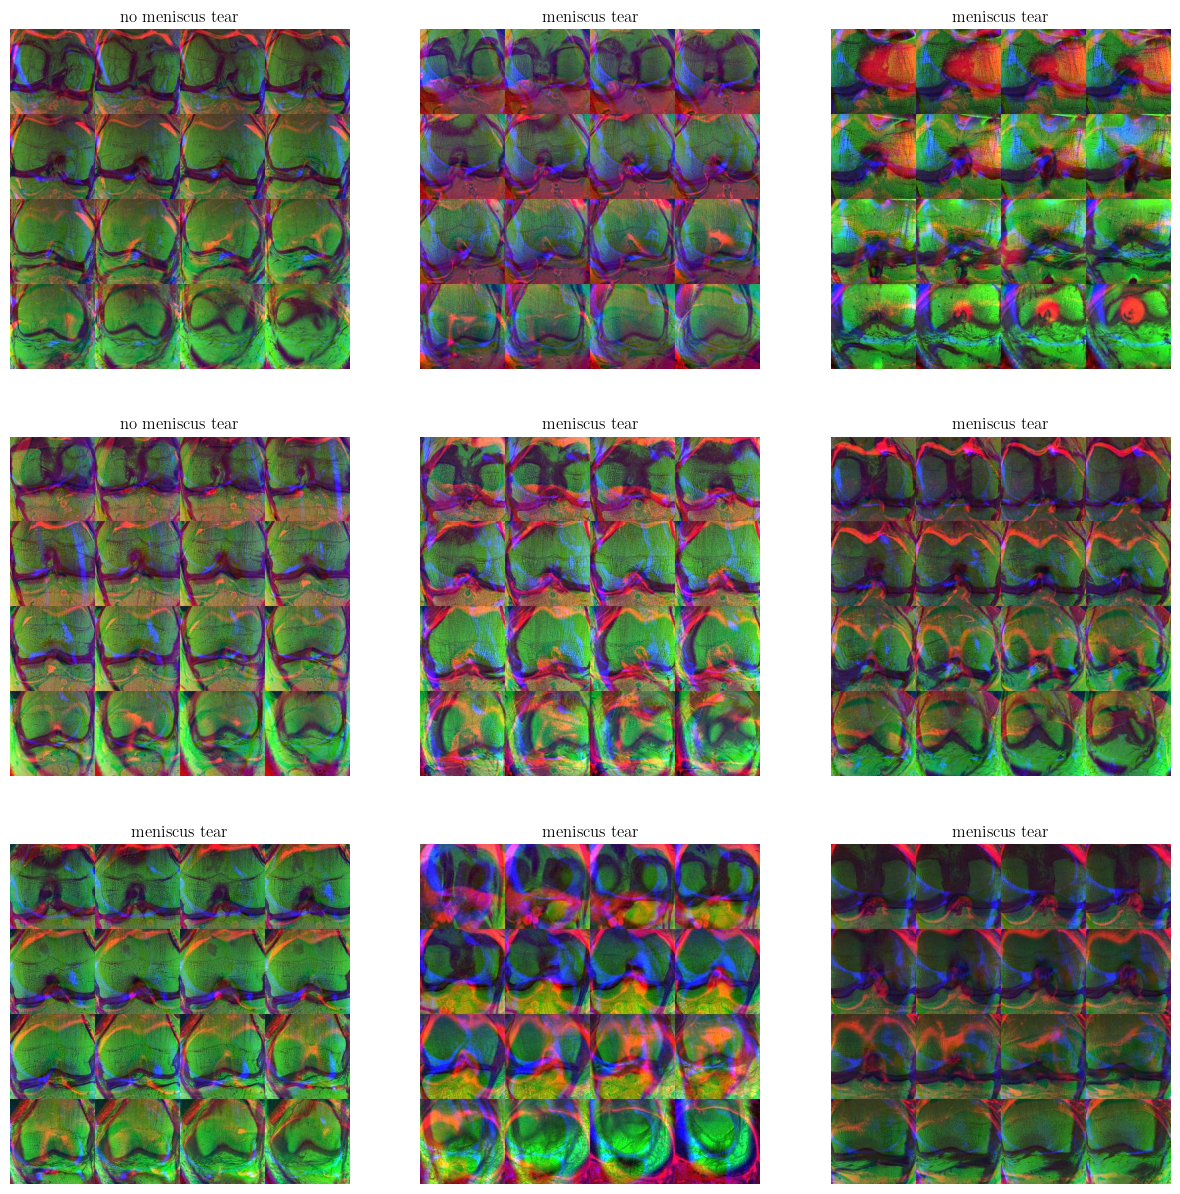

In [272]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    # plt.xlabel(
    plt.axis("off")
    
    
    

In [6]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

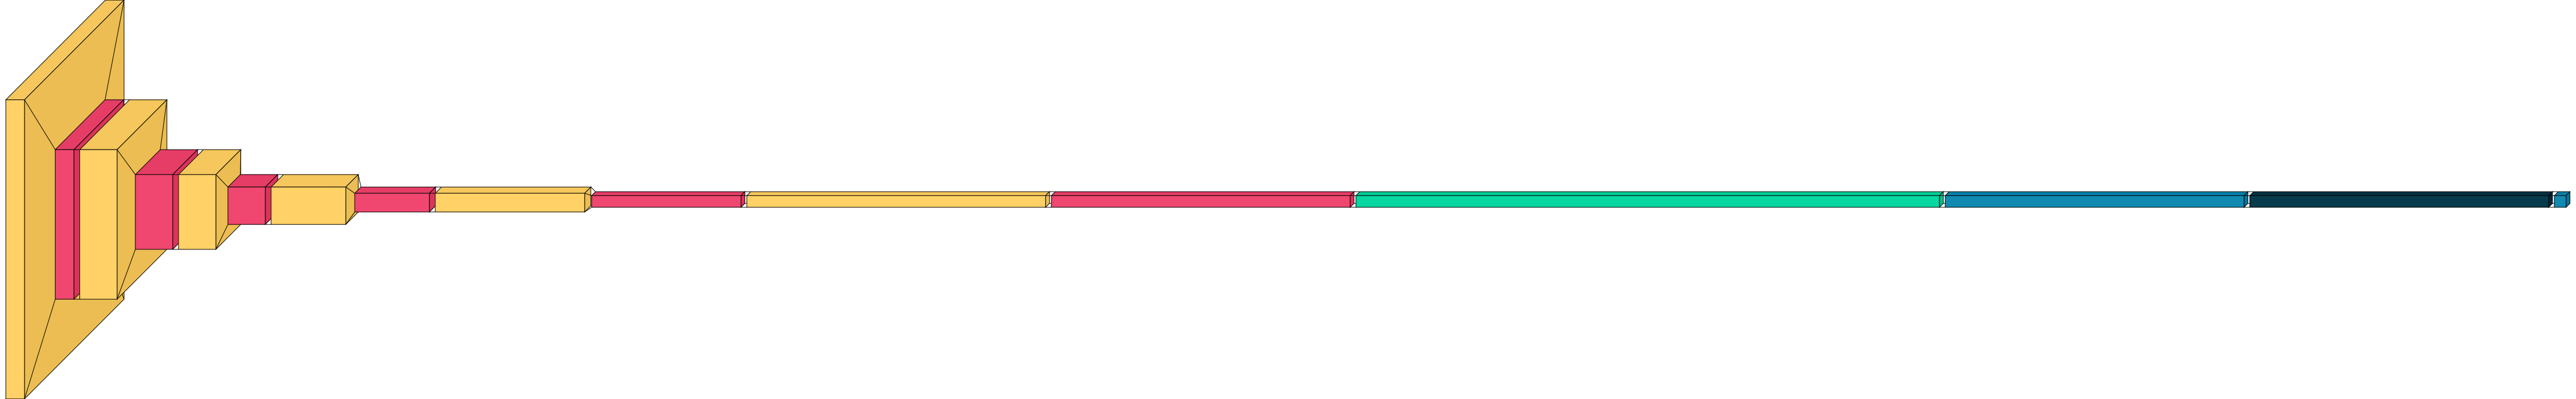

In [12]:
from tensorflow.keras.models import Sequential #functional API exists aswell for fancier stuff
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import visualkeras

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(512, 512, 3), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for Dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Single output neuron for binary classification


early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience =5,
                               verbose=1,
                               restore_best_weights = True)

visualkeras.layered_view(model, scale_xy=1, scale_z=1, max_z=1000)
# tf.keras.utils.plot_model(model, to_file='tf img classification ex model.svg', show_shapes=True)

In [13]:

#########scheduled learning rate (variable) ##########

# def lr_scheduler(epoch, lr):
#     learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]  # Add more learning rates to test
#     new_lr = learning_rates[epoch // 5] if epoch < 20 else lr
#     return new_lr

# num_epochs = 20  # Set your desired number of epochs
# # Create an array of epochs
# epochs = np.arange(0, num_epochs)

# # Calculate the learning rates for each epoch
# learning_rates = [lr_scheduler(epoch, 0.001) for epoch in epochs]

# # Plot the scheduled learning rates
# plt.figure(figsize=(8, 6))
# plt.plot(epochs, learning_rates, marker='o', linestyle='-', color='b')
# plt.title('Scheduled Learning Rate vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Learning Rate')
# plt.grid(True)
# plt.show()
# lr_callback = LearningRateScheduler(lr_scheduler)
# optimizer = Adam()
# # Compile the model with the Adam optimizer
# model.compile(optimizer=optimizer,
#               # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               loss = tf.keras.losses.BinaryCrossentropy(), #for binary classification
#               metrics=['accuracy'])

# ######### manual learning rate##########
from tensorflow.keras.optimizers import Adam


custom_learning_rate = 0.0001 # Set your desired learning rate
optimizer = Adam(learning_rate=custom_learning_rate)
# optimizer = tf.keras.optimizers.experimental.Adadelta
model.compile(optimizer=optimizer,
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = tf.keras.losses.BinaryCrossentropy(), #for binary classification
              metrics=['accuracy'])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 512, 512, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 256, 256, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 64)      51264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 64)       

In [14]:
#use some of the training data as test data: 
print("Len of train data before splitting:", int(len(train_ds)))
train_size = int(len(train_ds)*.8) #70% for training
test_size = int(len(train_ds)*.2) #10% for testing might need to add some batches (+...) because int will round down

print("train_size",train_size)
print("test_size", test_size)

# train_ds_final = train_ds.take(train_size)
# test_ds_final = train_ds.skip(train_size-1).take(test_size) #skips everything already used and taking the rest

train_ds_final = train_ds.take(train_size)
test_ds_final = train_ds.skip(train_size)
print("Len of created train_ds_final",len(train_ds_final))
print("Len of created test_ds",len(test_ds_final))

Len of train data before splitting: 25
train_size 20
test_size 5
Len of created train_ds_final 20
Len of created test_ds 5


In [15]:
epochs = 30
history = model.fit(
  train_ds_final,
  validation_data=val_ds,
  callbacks=[early_stopping],
  epochs=epochs
)

Epoch 1/30
20/20 [==============================] - 163s 8s/step - loss: 4.1804 - accuracy: 0.4850 - val_loss: 3.9676 - val_accuracy: 0.5238
Epoch 2/30
20/20 [==============================] - 161s 8s/step - loss: 3.7884 - accuracy: 0.5165 - val_loss: 3.5990 - val_accuracy: 0.5524
Epoch 3/30
20/20 [==============================] - 141s 7s/step - loss: 3.4372 - accuracy: 0.5717 - val_loss: 3.2677 - val_accuracy: 0.5619
Epoch 4/30
20/20 [==============================] - 142s 7s/step - loss: 3.1125 - accuracy: 0.6079 - val_loss: 2.9607 - val_accuracy: 0.5524
Epoch 5/30
20/20 [==============================] - 139s 7s/step - loss: 2.8330 - accuracy: 0.6425 - val_loss: 2.7145 - val_accuracy: 0.5714
Epoch 6/30
20/20 [==============================] - 140s 7s/step - loss: 2.6060 - accuracy: 0.6551 - val_loss: 2.4982 - val_accuracy: 0.6000
Epoch 7/30
20/20 [==============================] - 140s 7s/step - loss: 2.3684 - accuracy: 0.7134 - val_loss: 2.3501 - val_accuracy: 0.5905
Epoch 8/30
20

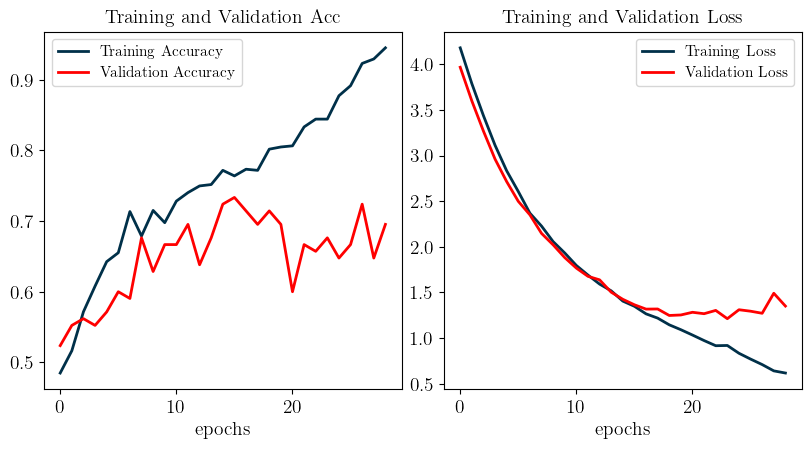

In [17]:
from matplotlib import rc
usetex = True
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)[:29]

plt.figure(figsize=(8, 8),constrained_layout=True)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth = 2, color='#003049')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth = 2, color = 'r')
plt.legend(loc='lower right')
plt.title('Training and Validation Acc', fontsize = 14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel("epochs", fontsize = 14)
plt.legend(prop={'size': 11})
ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
# plt.axis('scaled')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth = 2, color='#003049')
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth = 2, color = 'r')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize = 14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel("epochs", fontsize = 14)
plt.legend(prop={'size': 11})
ax = plt.gca()
ax.set_box_aspect(1)
# ax.set_aspect('equal', adjustable='box')
# plt.axis('scaled')
# plt.tight_layout()
plt.savefig("TrainingAcc and Loss.png", dpi = 500)
plt.show()

<font size=5> Evaluate on test data (gives unrealistically good results - haven't figured out why)

1/1 [==============================] - 2s 2s/step
class [1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0]
pred int: [1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 0. 0. 0.]
pred: [0.85 0.12 0.03 0.64 0.79 0.37 0.15 0.76 0.05 0.28 0.15 0.79 0.21 0.96
 0.64 0.54 0.63 0.1  0.77 0.2  0.25 0.   0.05 0.96 0.81 0.14 0.02 0.95
 0.09 0.   0.33 0.47]
1/1 [==============================] - 2s 2s/step
class [1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0]
pred int: [1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0.]
pred: [0.68 0.89 0.06 0.91 0.17 0.79 0.34 0.91 0.25 0.05 0.   0.06 0.05 0.
 0.16 0.09 0.71 0.12 0.2  0.8  0.03 0.01 0.26 0.58 0.02 0.81 0.31 0.59
 0.96 0.03 0.87 0.06]
1/1 [==============================] - 2s 2s/step
class [0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0]
pred int: [0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0

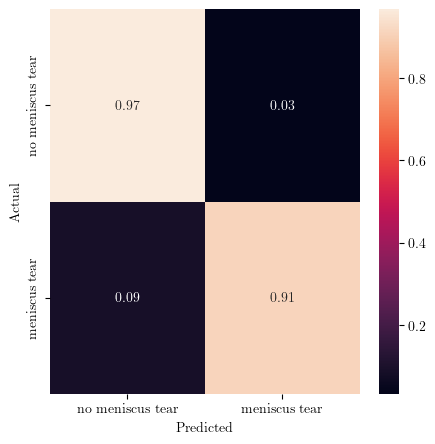

In [20]:

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC, SparseCategoricalAccuracy, CategoricalAccuracy, Accuracy
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import brier_score_loss

pre = Precision()
re = Recall()
acc = BinaryAccuracy() #for binary model (2 classes)
AUC = AUC()


test_labels_total = np.array([])
model_predictions_total = np.array([])
for batch in iter(test_ds_final): 
    X, y = batch #X are images, y are labels for the batch
    y = np.array(y)
    test_labels_total = np.concatenate((test_labels_total.astype(int), y.astype(int)))
    
    yhat = model.predict(X)
    # yhat = np.argmax(yhat, axis=1) #if not using sigmoid on last dense layer and using softmax instead
    model_predictions_total = np.concatenate((model_predictions_total.astype(int),np.round(yhat.flatten()).astype(int)))
    print("class",y)
    print("pred int:", np.array2string(np.round(yhat.flatten())))
    print("pred:",np.array2string(yhat.flatten(), precision=2))
    # plt.imshow(X[0])
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    AUC.update_state(y, yhat)
    
# test_labels_total = np.array(test_labels_total)
# model_predictions_total = np.array(model_predictions_total)
    
print("TEST DATASET Precision: {:.3f}, Recall: {:.3f}, Accuracy: {:.3f}, AUC: {:.3f}".format(pre.result().numpy(), re.result().numpy(), acc.result().numpy(), AUC.result().numpy()))
print("matthews corr-coef", metrics.matthews_corrcoef(test_labels_total,model_predictions_total))
print(metrics.classification_report(test_labels_total,model_predictions_total, target_names=class_names))
# Calculate Brier score
brier = brier_score_loss(test_labels_total, model_predictions_total)
print("Brier Score:", brier)

#generate confusion matrix of entire test classifical 
cm = metrics.confusion_matrix(test_labels_total,model_predictions_total )
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #can get rid of this line to un-normalize and have counts instead of probability
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

<font size=5> Evaluate on validation data (sanity check)


1/1 [==============================] - 0s 495ms/step
VALIDATION DATASET Precision: 0.655, Recall: 0.731, Accuracy: 0.676, AUC: 0.757
matthews corr-coef 0.355350085695063
                  precision    recall  f1-score   support

no meniscus tear       0.70      0.62      0.66        53
   meniscus tear       0.66      0.73      0.69        52

        accuracy                           0.68       105
       macro avg       0.68      0.68      0.68       105
    weighted avg       0.68      0.68      0.68       105

Brier Score: 0.3238095238095238
1/1 [==============================] - 0s 81ms/step
class: 0
0.5511654
1/1 [==============================] - 0s 68ms/step
class: 1
0.8861976
1/1 [==============================] - 0s 68ms/step
class: 0
0.5751746
1/1 [==============================] - 0s 70ms/step
class: 1
0.8865564
1/1 [==============================] - 0s 70ms/step
class: 1
0.76981956
1/1 [==============================] - 0s 70ms/step
class: 0
0.05570186
1/1 [==============

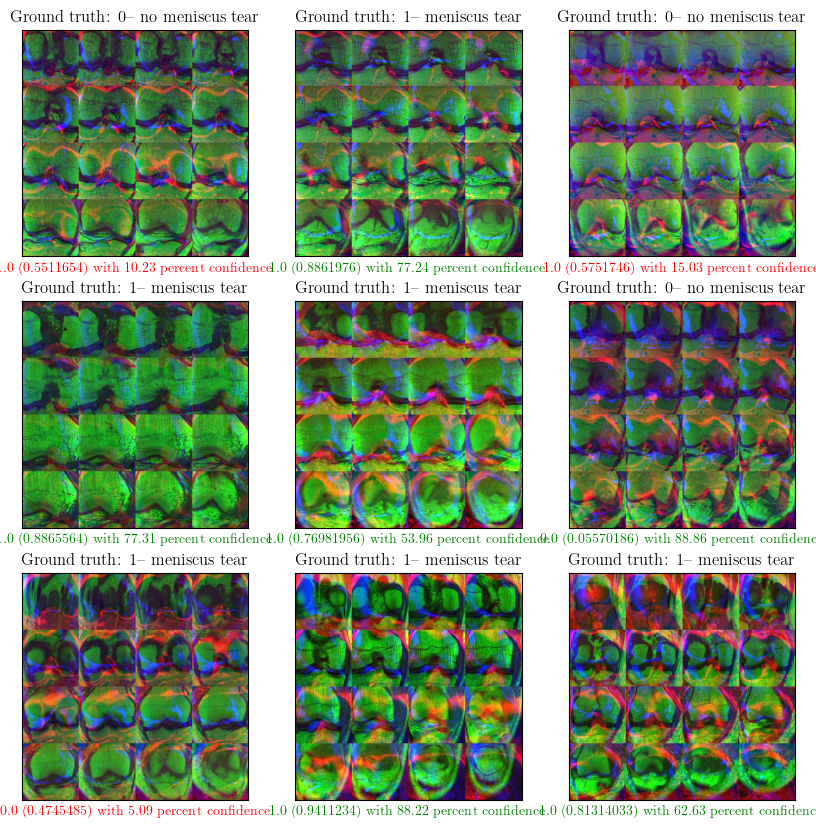

In [139]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC, SparseCategoricalAccuracy, CategoricalAccuracy, Accuracy
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import brier_score_loss
def get_confidence(prediction):
    return abs(prediction - 0.5) * 2 * 100
pre = Precision()
re = Recall()
acc = BinaryAccuracy() #for binary model (2 classes)
# acc = Accuracy() #for multi class model
AUC = AUC()

test_labels_total = np.array([])
model_predictions_total = np.array([])
for batch in iter(val_ds): 
    X, y = batch #X are images, y are labels for the batch
    y = np.array(y)
    test_labels_total = np.concatenate((test_labels_total.astype(int), y.astype(int)))
    yhat = model.predict(X)
    model_predictions_total = np.concatenate((model_predictions_total.astype(int),np.round(yhat.flatten()).astype(int)))
    # print("class",y)
    # print("pred int:", np.array2string(np.round(yhat.flatten())))
    # print("pred:",np.array2string(yhat.flatten(), precision=2))
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    AUC.update_state(y, yhat)

print("VALIDATION DATASET Precision: {:.3f}, Recall: {:.3f}, Accuracy: {:.3f}, AUC: {:.3f}".format(pre.result().numpy(), re.result().numpy(), acc.result().numpy(), AUC.result().numpy()))
print("matthews corr-coef", metrics.matthews_corrcoef(test_labels_total,model_predictions_total))
print(metrics.classification_report(test_labels_total,model_predictions_total, target_names=class_names))
# Calculate Brier score
brier = brier_score_loss(test_labels_total, model_predictions_total)
print("Brier Score:", brier)

#plot some example images and classifications from a batch
test_image_batch, test_labels_batch = next(iter(val_ds))
test_labels_batch = np.array(test_labels_batch)
# # prediction = probability_model.predict(test_image_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_image_batch[i].numpy())
    y_true = test_image_batch[i]
    img_array = tf.keras.utils.img_to_array(test_image_batch[i])
    img_array = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array)# Create a batch
    confidence = get_confidence(prediction.flatten()[0])
    print("class:", test_labels_batch[i])
    print(prediction.flatten()[0])
    plt.title("Ground truth: " + str(test_labels_batch[i])+ "-- " + str(class_names[test_labels_batch[i]]))
    if test_labels_batch[i] == np.round(prediction):
        plt.xlabel(str(np.round(prediction.flatten()[0])) + " ("  + str(prediction.flatten()[0]) +")"+  " with {:.2f} percent confidence".format(confidence), color = 'g')
    else:
        plt.xlabel(str(np.round(prediction.flatten()[0])) + " ("  + str(prediction.flatten()[0])+")"+ " with {:.2f} percent confidence".format(confidence), color = 'r')
    
# true = []
# pred = []
# for i in range(30):
#     y_true = test_labels_batch[i]
#     img_array = tf.keras.utils.img_to_array(test_image_batch[i])
#     img_array = tf.expand_dims(img_array, 0)
#     prediction = model.predict(img_array)# Create a batch
    
#     # print("y_true:", y_true)
#     # print("y_pred:", prediction.flatten()[0])
#     true.append(y_true)
#     pred.append(prediction.flatten()[0])
   
# print("True", "Int pred", "Pred")
# for i in range(len(true)):
    
#     print(true[i],np.round(pred[i]), pred[i])

    
    

In [ ]:

model.save(os.path.join('models','binary_meniscus_bal_data_adam_lr_0.0005.h5'))


In [141]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('binary_meniscus_bal_data_adam_lr_0.0005', 'wb') as f:
  f.write(tflite_model)